In [5]:
import numpy as np
from collections import OrderedDict as odict
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [6]:
#(hardware name, number of nodes)
filesD = {
         'knl_mpi1':('knl',1), 'knl_mpi2':('knl',2), 'knl_mpi4':('knl',4),
         'skl_mpi1':('skl',1), 'skl_mpi2':('skl',2), 'skl_mpi4':('skl',4),
         'i5':('i5',1),
         'p100_mpi1':('p100',1), 'p100_mpi2':('p100',2), 'p100_mpi4':('p100',4),
         'v100_mpi1':('v100',1), 'v100_mpi2':('v100',2), 'v100_mpi4':('v100',4),
         'gtx1060':('gtx1060',1)
                      }
# order by number of nodes to make labeling easier further down
files = odict(sorted(filesD.items(), key= lambda t : t[1][1]))
# count number of 1 nodes in dict
number=0
for k,v in files.items(): 
    if v[1]==1: number+=1
arch = {'knl':(cm.Greens,450,0.7),'skl':(cm.Greys,205,0.7),'p100':(cm.Blues,550,0.7),'v100':(cm.Purples,850,0.7),
        'i5':(cm.Wistia,30,0.5),'gtx1060':(cm.Oranges,157,0.5)}
intens={1:0.8, 2:0.6, 4:0.4}

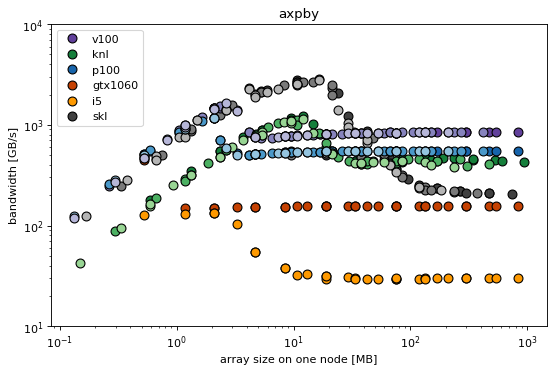

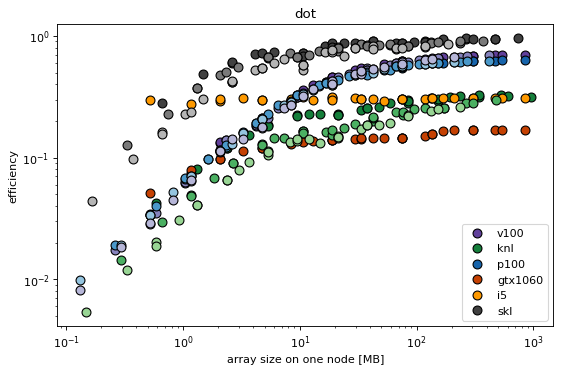

In [7]:
for q in ('axpby','dot'):
    fig,ax=plt.subplots(1,1,figsize=(8,5),dpi= 80, facecolor='w', edgecolor='k')
    for f, v in files.items():  
        #read in csv file
        df=pd.read_csv('benchmark_'+f+'.csv', delimiter=' ')
        #add size and get rid of non-relevant columns
        df.insert(0,'size', 8*df['n']*df['n']*df['Nx']*df['Ny']/1e6/v[1])
        bw = df[['n','Nx','Ny','size']]
        bw = bw.assign(axpby = df['size']/1000*3/df['axpby'])
        bw = bw.assign(dot = df['size']/1000*2/df['dot']/arch[v[0]][1])
        #compute mean and standard derivation of 'same' groups 
        bw=bw.groupby(['n', 'Nx','Ny','size']).agg(['mean', 'std'])
        bw=bw.reset_index(level=['n','Nx','Ny','size'])
        bw=bw.sort_values(by='size')
        #print(f,v[0], matplotlib.colors.to_rgb(color))
        bw[q].plot(ax=ax,color=arch[v[0]][0](intens[v[1]]), marker='o',ls='',markeredgecolor='k',
                    x=bw.loc[:,'size'],y='mean',markersize=8,label=v[0])#+' ('+str(arch[v[0]][1])+')')
    plt.xlabel('array size on one node [MB]')
    plt.xscale('log')
    plt.yscale('log')
    #for k,v in arch.items():
    #    if q=='axpby' : 
    #        plt.axhline(y=v[1],xmin=v[2],xmax=1,color=v[0](1.0),lw=2)

    handles, labels = plt.gca().get_legend_handles_labels()
    handles = handles[0:number]; labels = labels[0:number]
    if q=='dot':
        plt.legend(handles, labels, loc='lower right',numpoints=1)
        plt.ylabel('efficiency')

    else:
        plt.legend(handles, labels, loc='upper left',numpoints=1)
        plt.ylabel('bandwidth [GB/s]')
        plt.ylim(10,1e4)

    plt.title(q)
    #plt.savefig(q+'.pdf')

intensity marks number of nodes: darkest 1 node, ligthest 4 nodes

##### Conclusions
- the linear increase in bandwidth with size is the latency dominated regime 
$$ \frac{b}{\text{GB/s}} = \left(\frac{t_{lat}}{\text{ms}}\right)^{-1} \left(\frac{s}{\text{MB}}\right) $$ where $b$ is the bandwidth and $s$ is the size. The slope (the intercept in the loglog plot) therefore is the inverse latency in milliseconds. To get it we simply average the timings for small sizes. 
- In the efficiency plot the slope times the base bandwidth is the inverse latency in milliseconds
- for dot GPU has high latency because it sends result to CPU, but why the KNL card?
- GPUs have smallest latencies in axpby, KNL highest ( do we see the generation of the OpenMP threads?)
- bandwidth dominated regime starts at around 10MB 
- especially in Skylake the cache effect in axpby is obvious: without communication vector just stays in cache of size 33MB
- total problem size on one node in both axpby and dot is 2 * array size
- size normalization for MPI reveals that it is indeed the single node bandwidth that counts, (if we simply divided bandwidth by # of nodes, we would falsely attribute performance loss to MPI communication)
- for small sizes the communication overhead in MPI becomes visible
- Skylake achieves almost 100% efficiency in dot product, followed by Tesla cards P100 and V100
